In [ ]:
!ls 

In [30]:

import torch 
import torch as th 
import torch.nn as nn
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [41]:
!ls {ckptdir}

0020000.pt  0200000.pt	0380000.pt  0560000.pt	0740000.pt  0920000.pt
0040000.pt  0220000.pt	0400000.pt  0580000.pt	0760000.pt  0940000.pt
0060000.pt  0240000.pt	0420000.pt  0600000.pt	0780000.pt  0960000.pt
0080000.pt  0260000.pt	0440000.pt  0620000.pt	0800000.pt  0980000.pt
0100000.pt  0280000.pt	0460000.pt  0640000.pt	0820000.pt  1000000.pt
0120000.pt  0300000.pt	0480000.pt  0660000.pt	0840000.pt
0140000.pt  0320000.pt	0500000.pt  0680000.pt	0860000.pt
0160000.pt  0340000.pt	0520000.pt  0700000.pt	0880000.pt
0180000.pt  0360000.pt	0540000.pt  0720000.pt	0900000.pt


In [4]:
!ls {repr_dir}

model_PCA_col_PC1024.pkl	results_col_t0_02_PC1024.pkl
model_PCA_col_PC2048.pkl	results_col_t0_05_PC1024.pkl
model_PCA_col_PC512.pkl		results_col_t0_1_PC1024.pkl
model_PCA_col_t0_02_PC1024.pkl	results_col_t0_3_PC1024.pkl
model_PCA_col_t0_05_PC1024.pkl	results_col_t0_5_PC1024.pkl
model_PCA_col_t0_1_PC1024.pkl	results_col_t0_7_PC1024.pkl
model_PCA_col_t0_3_PC1024.pkl	results_col_t0_9_PC1024.pkl
model_PCA_col_t0_5_PC1024.pkl	results_col_t1_0_PC1024.pkl
model_PCA_col_t0_7_PC1024.pkl	t0_02_PC1024_accuracy.pdf
model_PCA_col_t0_9_PC1024.pkl	t0_02_PC1024_accuracy.png
model_PCA_col_t1_0_PC1024.pkl	t0_05_PC1024_accuracy.pdf
PC_proj_col_PC1024.pkl		t0_05_PC1024_accuracy.png
PC_proj_col_PC2048.pkl		t0_1_PC1024_accuracy.pdf
PC_proj_col_PC512.pkl		t0_1_PC1024_accuracy.png
PC_proj_col_t0_02_PC1024.pkl	t0_3_PC1024_accuracy.pdf
PC_proj_col_t0_05_PC1024.pkl	t0_3_PC1024_accuracy.png
PC_proj_col_t0_1_PC1024.pkl	t0_5_PC1024_accuracy.pdf
PC_proj_col_t0_3_PC1024.pkl	t0_5_PC1024_accuracy.png
PC_proj_col_t0_5_P

In [31]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


In [22]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [23]:
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [44]:
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
    train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
    syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
    syn_df.columns = ["Test Accuracy", "Train Accuracy"]
    syn_df["t"] = t_scalar
    # drop index as layer name
    syn_df = syn_df.reset_index()
    syn_df = syn_df.rename(columns={"index": "Layer"})
    syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

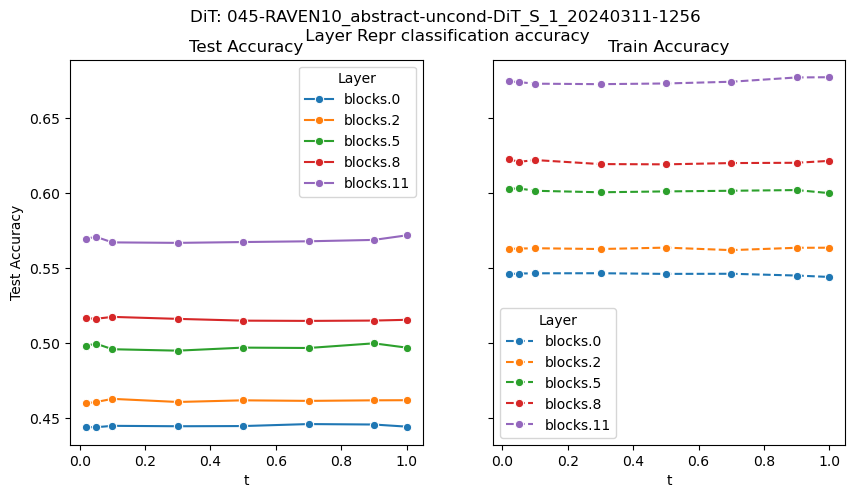

In [19]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="t", y="Test Accuracy", hue="Layer", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="t", y="Train Accuracy", hue="Layer", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

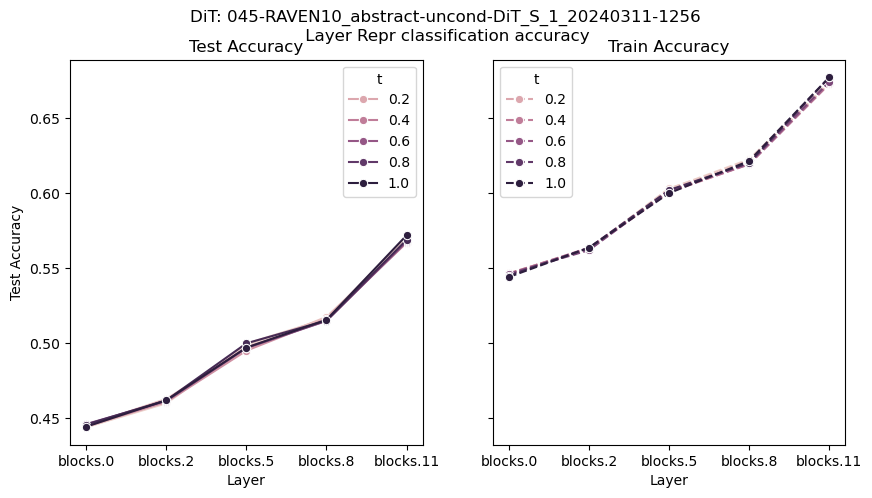

In [45]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="t", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="Layer", y="Train Accuracy", hue="t", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

In [46]:
for t in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    syn_df = syn_df_all[syn_df_all["t"]==t]
    print(f"t={t}")
    print(syn_df)

t=0.02
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444175        0.545925  0.02
1   blocks.2       0.460025        0.562658  0.02
2   blocks.5       0.498350        0.602717  0.02
3   blocks.8       0.516600        0.622467  0.02
4  blocks.11       0.569600        0.674267  0.02
t=0.05
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444125        0.546400  0.05
1   blocks.2       0.460900        0.563008  0.05
2   blocks.5       0.499700        0.603025  0.05
3   blocks.8       0.516300        0.620725  0.05
4  blocks.11       0.570775        0.673783  0.05
t=0.1
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.445050        0.546550  0.1
1   blocks.2       0.463000        0.563225  0.1
2   blocks.5       0.496025        0.601467  0.1
3   blocks.8       0.517550        0.621917  0.1
4  blocks.11       0.567125        0.672733  0.1
t=0.3
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.444775    

In [48]:
9 * 9 * 3

243

In [36]:
from matplotlib.patches import Rectangle

def visualize_cm(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    for rule_id in heldout_rules:
        row = rule_id // 10
        col = rule_id % 10
        plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()

In [37]:
results_col['blocks.0']['pred_cls']

tensor([32,  0, 19,  ..., 39, 39, 39], device='cuda:0')

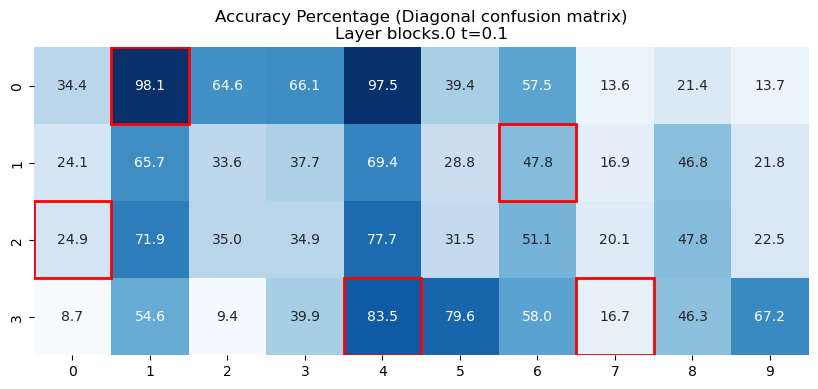

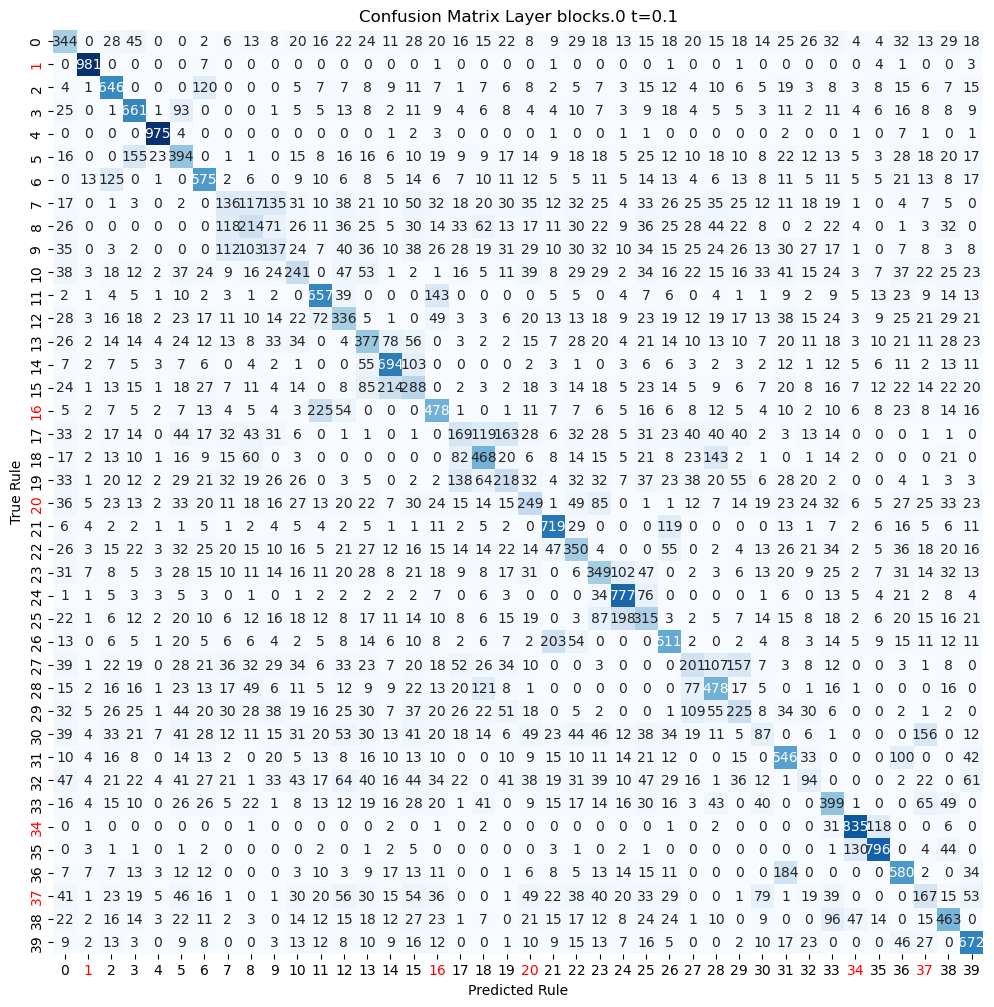

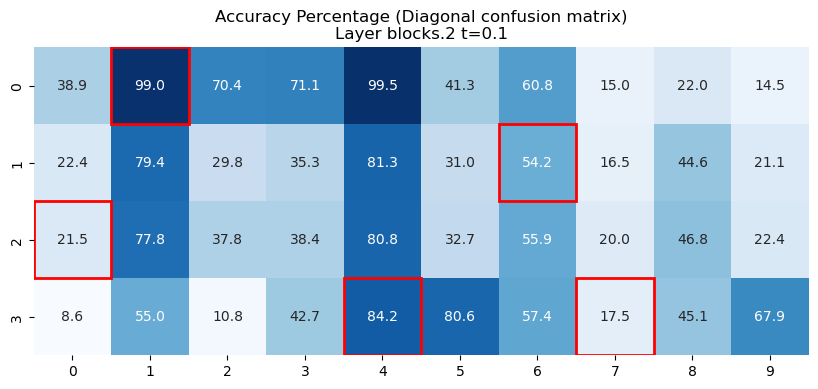

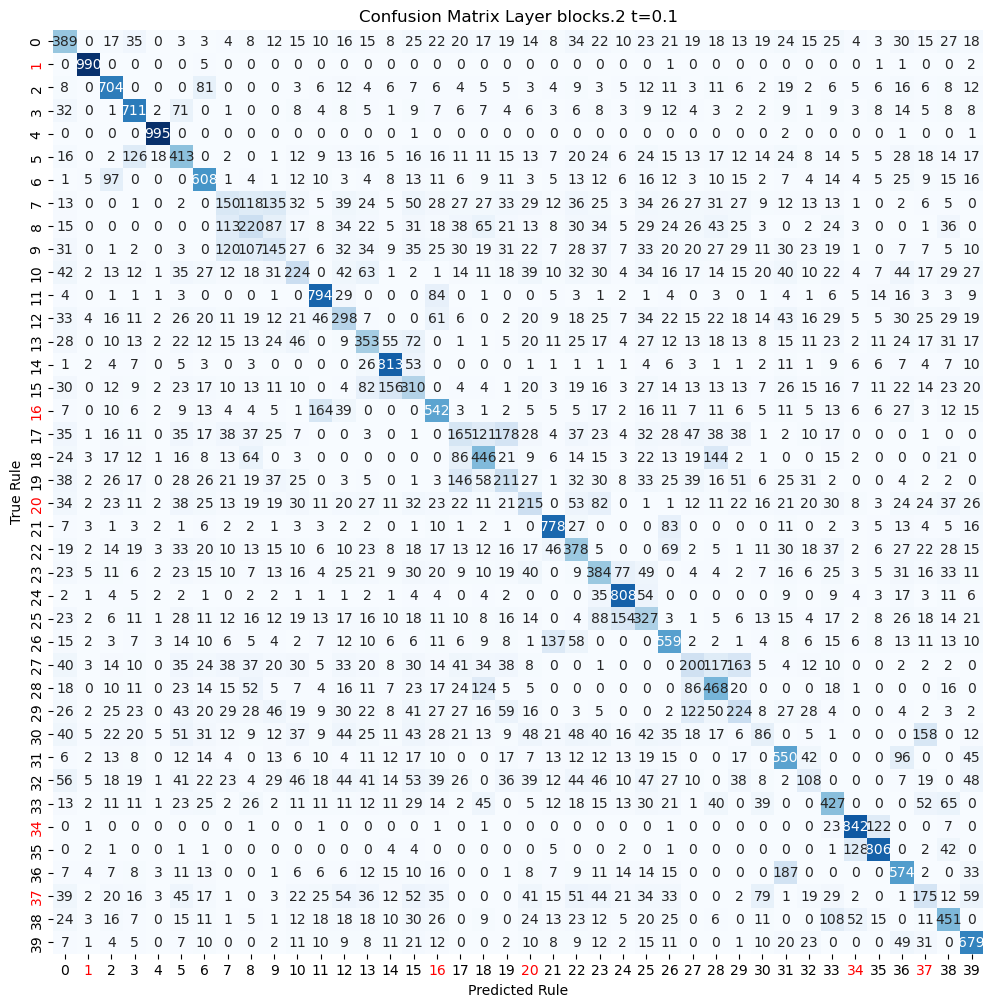

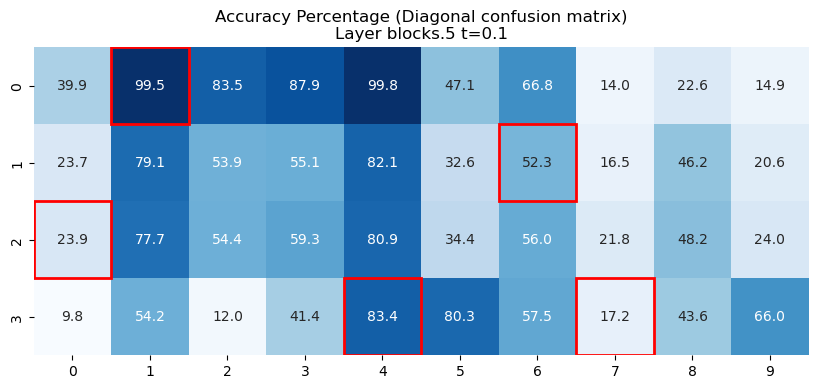

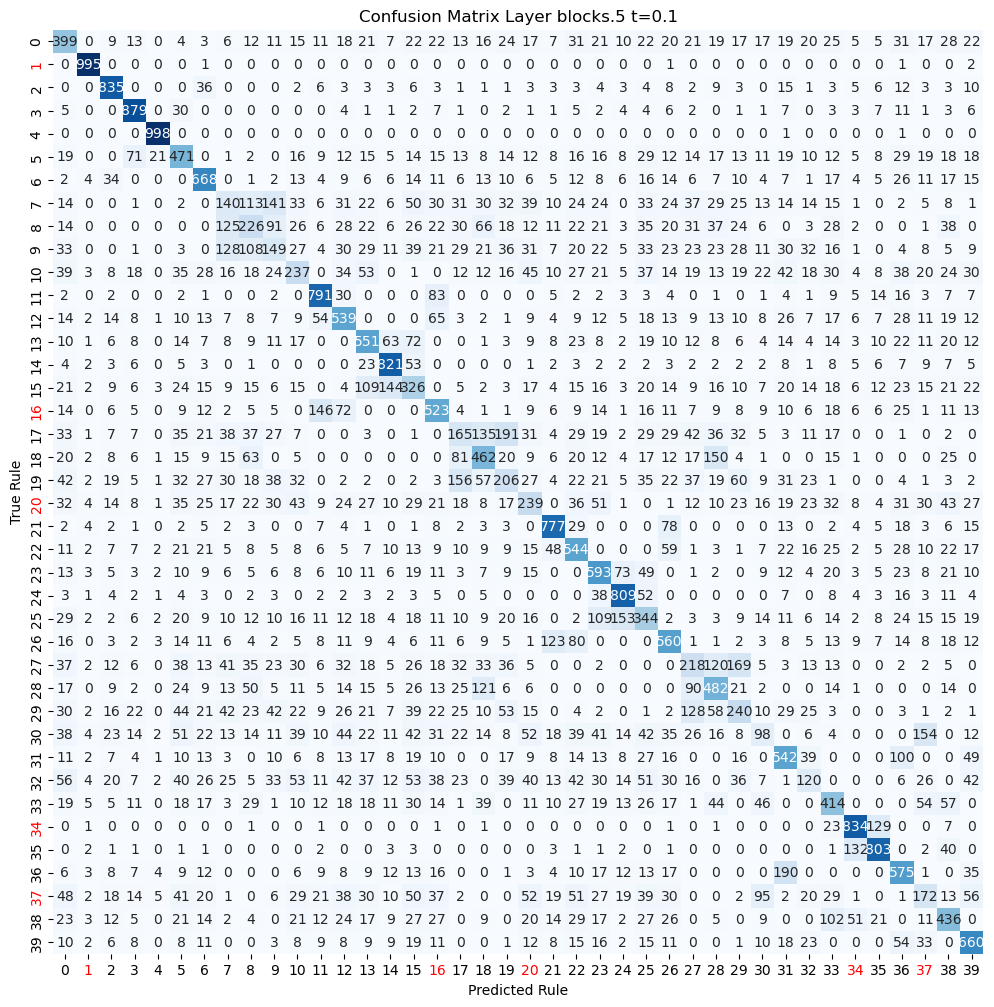

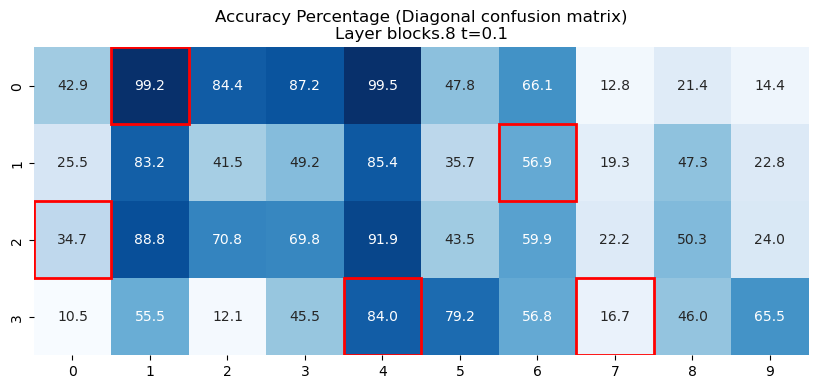

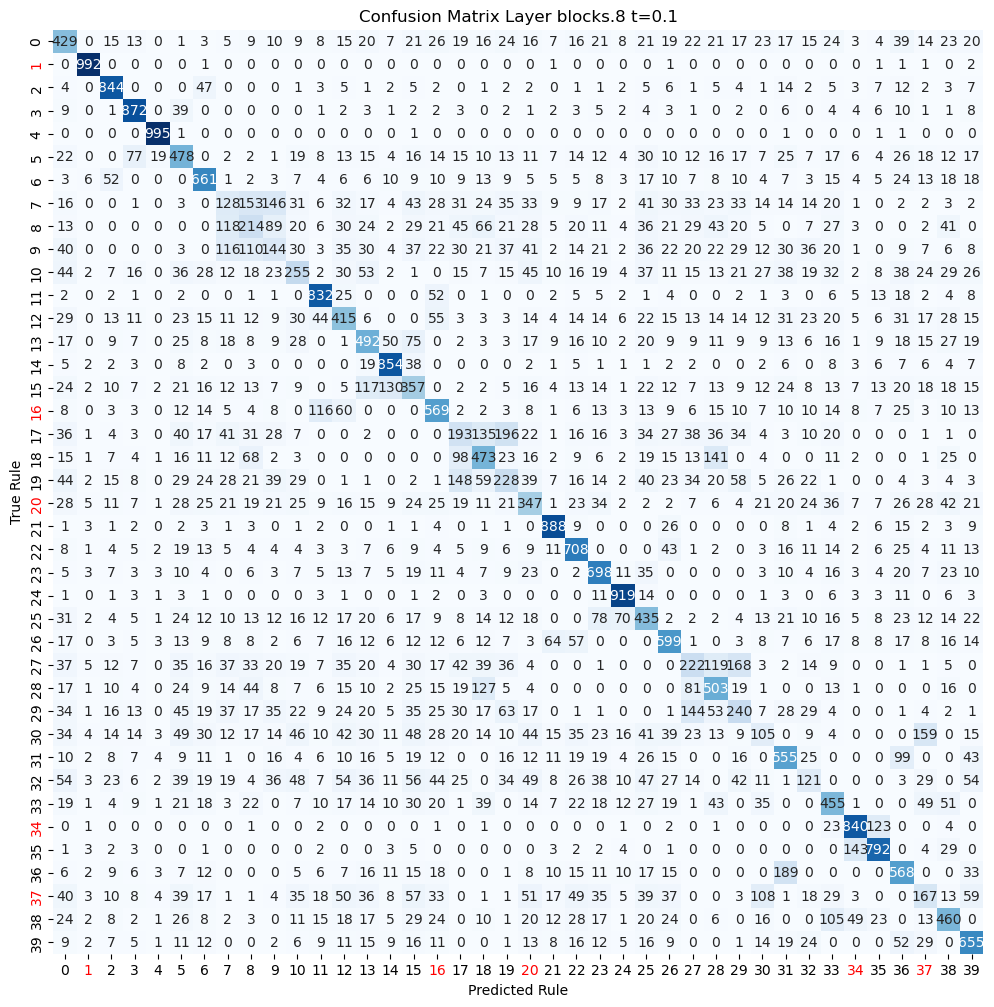

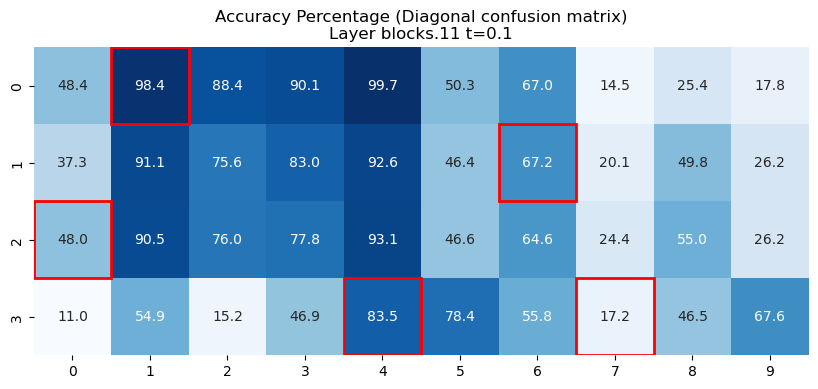

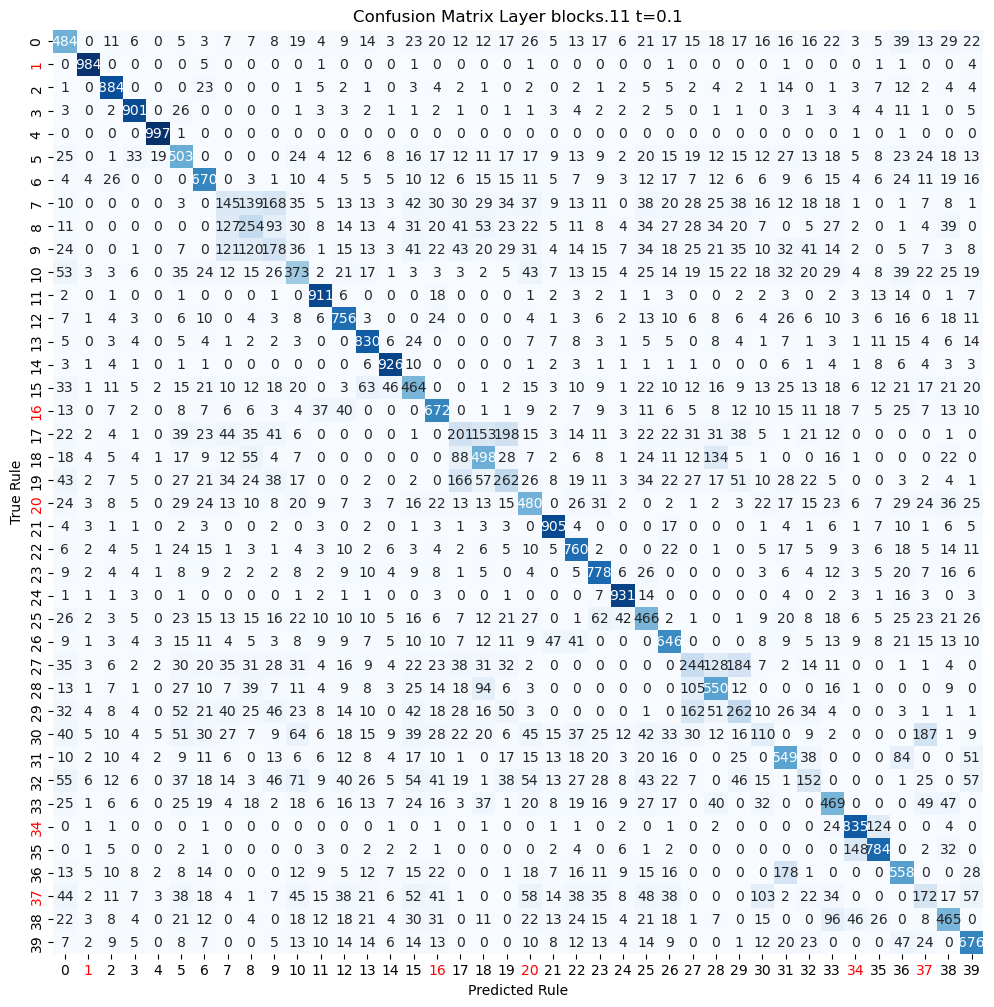

In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.1]:#[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")